# Simple Walk 2D continuous

base environment on https://github.com/nicknochnack/ReinforcementLearningCourse/blob/main/Project%203%20-%20Custom%20Environment.ipynb

continuous state space environment

action space: BOX in two directions from -1 to 1

state space: box with shape(2,1)?

goal reached when distance closer than 1





## 1. Import Dependencies

In [114]:
import gym 
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 
import numpy as np
import random
import os
from stable_baselines3 import PPO, TD3, A2C
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy

import matplotlib.pyplot as plt

# logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


## Env Class

In [128]:
class SimpleWalk2Dcont(Env):
    """simple walk environment in 2D with a continuous action and state space"""
    def __init__(self):
        self.x_min = 0.0
        self.x_max = 10.0
        self.max_steps = 15
        self.action_space = Box(low=-1.0, high=1.0, shape=(2, ))
        self.observation_space = Box(low=self.x_min, high=self.x_max, shape=(4, )) # x,y position, x,y goal
        self.state = np.ndarray(shape=(4,), dtype=np.float32)
        # safe past states in an array, safe x and y positions
        
    def __out_of_bounds(self):
        """check if the current state is out of bounds"""
        position = self.state[0:2]
        for element in position:
            if not (self.x_min <= element <= self.x_max):
                
                return True
            else:
                return False
            
    def __append_state(self):
        self.state_array[0].append(self.state[0])
        self.state_array[1].append(self.state[1])
        
    def __distance_to_goal(self):
        distance_to_goal = np.linalg.norm(self.state[0:2] - self.state[2:4])
        return distance_to_goal     
        
    
    def step(self, action):
        previous_state = self.state
        # update position
        self.state[0] += action[0] # update x
        self.state[1] += action[1] # update y
        self.__append_state()
        new_state = self.state
        self.steps_taken += 1
        distance_to_goal = self.__distance_to_goal()
    
        if self.steps_taken >= self.max_steps:
            # maximum number of steps reached
            logging.debug("maximum number of steps reached")
            reward = -2000.0
            done = True
        elif self.__out_of_bounds():
            # went out of bounds
            logging.debug("out of bounds")
            reward = -1000.0
            done = True
        elif distance_to_goal < 1:
            # reached goal
            reward = 2000.0
            logging.debug("reached goal")
            done = True
        elif False: # self.distance_to_goal > distance_to_goal:
            # got closer
            logging.debug("got closer")
            reward = (self.distance_to_goal - distance_to_goal) * 20
            done = False
        else:
            
            movement = self.distance_to_goal - distance_to_goal
            logging.debug("movement: {}".format(movement))
            reward = movement * 100 - 500
            done = False
        
        # update distance to goal
        self.distance_to_goal = distance_to_goal
        info = {'distance_to_goal': self.distance_to_goal, 
                'steps_taken': self.steps_taken,
                'previous_state': previous_state,
                'new_state': new_state}
        
        return self.state, reward, done, info
    
    def reset(self):
        """reset and initalize the environment"""
        
        self.state = np.random.uniform(self.x_min, self.x_max, (4,))
        self.state_array = [[], []] # x, y
        self.__append_state()
        self.steps_taken = 0
        self.distance_to_goal = self.__distance_to_goal()
        logging.debug("init distance to goal: {}".format(self.distance_to_goal))
        return self.state
    
    def render(self):
        
        logging.debug("visited states: ", self.state_array)
        logging.debug("x: {}".format(self.state_array[0]))
        logging.debug("y: {}".format(self.state_array[1]))
        goal = self.state[2:4]
        logging.debug("goal: {}".format(goal))
        
        
        # plot
        fig, ax = plt.subplots()

        # plot the visited states
        ax.plot(self.state_array[0], self.state_array[1], linewidth=2.0, marker='x')
        
        # plot the goal
        ax.plot(goal[0], goal[1], 'ro')
        circle1 = plt.Circle((goal[0], goal[1]), 1, color='r', fill=False)
        ax.add_patch(circle1)
        ax.set(
            xlim=(self.x_min, self.x_max), #xticks=np.arange(1, 8),
            ylim=(self.x_min, self.x_max), #yticks=np.arange(1, 8))
            )
        plt.show()
        
    

    
env = SimpleWalk2Dcont()

print(env.action_space.sample())
print(env.observation_space.sample())

[-0.01194014  0.5170296 ]
[7.5857744 4.475587  4.6464    6.593027 ]


In [116]:
a= [5.450801, 3.7648005, 0.2729502, 8.326116,]
a[2:4]

[0.2729502, 8.326116]

## Check Environment

### random walk

DEBUG:root:init distance to goal: 7.5102270994073015
DEBUG:root:movement: -0.370609049637487
DEBUG:root:Steps taken: 1
DEBUG:root:distance to goal: 7.8808361490447885
DEBUG:root:reward: -537.0609049637487
DEBUG:root:movement: -0.1584831464277352
DEBUG:root:Steps taken: 2
DEBUG:root:distance to goal: 8.039319295472524
DEBUG:root:reward: -515.8483146427735
DEBUG:root:movement: 0.5957996141446573
DEBUG:root:Steps taken: 3
DEBUG:root:distance to goal: 7.443519681327866
DEBUG:root:reward: -440.42003858553426
DEBUG:root:movement: -0.5315813848975299
DEBUG:root:Steps taken: 4
DEBUG:root:distance to goal: 7.975101066225396
DEBUG:root:reward: -553.158138489753
DEBUG:root:movement: 0.5905756989031987
DEBUG:root:Steps taken: 5
DEBUG:root:distance to goal: 7.3845253673221976
DEBUG:root:reward: -440.9424301096801
DEBUG:root:movement: -0.08363807804516377
DEBUG:root:Steps taken: 6
DEBUG:root:distance to goal: 7.468163445367361
DEBUG:root:reward: -508.3638078045164
DEBUG:root:movement: -0.18335560288

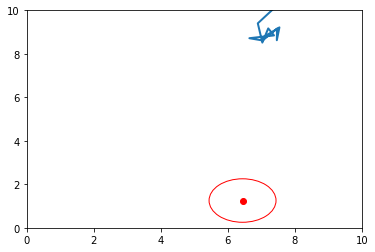

In [117]:
env = SimpleWalk2Dcont()
episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        # env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        logging.debug('Steps taken: {}'.format(info['steps_taken']))
        logging.debug('distance to goal: {}'.format(info['distance_to_goal']))
        logging.debug('reward: {}'.format(reward))
        score+=reward
    logging.info('Episode:{} Score:{}'.format(episode, score))
    env.render()
env.close()

### env_checker

In [118]:
from stable_baselines3.common import env_checker
env_checker.check_env(env)

DEBUG:root:init distance to goal: 3.261443426524627
DEBUG:root:movement: 0.8359649735678478
DEBUG:root:movement: -0.6351648397265248
DEBUG:root:movement: 0.2219429356202225
DEBUG:root:movement: 0.02310854751762026
DEBUG:root:movement: -0.13290220054400015
DEBUG:root:movement: -0.6143448803658038
DEBUG:root:movement: -0.33945803959120235
DEBUG:root:movement: -0.3579817057397654
DEBUG:root:movement: 0.8042928294221396
DEBUG:root:movement: -0.21350035846893167
DEBUG:root:movement: 0.29828242040685904


## Callback

In [119]:
# create callback fun

import os
from stable_baselines3.common.callbacks import BaseCallback

class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok = True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

env_name = 'Walk2Dcont'

CHECKPOINT_DIR = './train/train_' + env_name
LOG_DIR = './train/log_' + env_name

callback = TrainAndLoggingCallback(check_freq=10_000, save_path=CHECKPOINT_DIR)

## Train

In [120]:
log_path = os.path.join('Training', 'Logs')

model = PPO(
    "MlpPolicy", 
    env, 
    verbose=1, 
    tensorboard_log=log_path,
    learning_rate=0.0005,
    n_steps = 1028
    )


In [121]:
model = TD3('MlpPolicy', 
          env, 
          tensorboard_log=log_path,
          )

In [122]:
logger.setLevel(logging.INFO)
model.learn(
    total_timesteps=100_000, 
    callback = callback
    )

In [123]:
model.save('TD3_' + env_name)
logger.setLevel(logging.DEBUG)

## Test Model

DEBUG:root:init distance to goal: 4.123744373827174
DEBUG:root:movement: 0.9365015150642031
DEBUG:root:movement: 0.9516541308537314
DEBUG:root:movement: 1.136117657533842
DEBUG:root:reached goal
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Luttk\.vscode-insiders\extensions\ms-toolsai.jupyter-2022.1.1001614873\pythonFiles\vscode_datascience_helpers\kernel_prewarm_starter.py", line 31, in <module

info {'distance_to_goal': 0.25869221844536827, 'steps_taken': 4, 'previous_state': array([0.84216336, 6.2235008 , 0.63088748, 6.37277962]), 'new_state': array([0.84216336, 6.2235008 , 0.63088748, 6.37277962])}


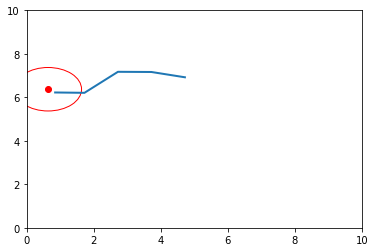

In [124]:
# test prediction
env = SimpleWalk2Dcont()
env.reset()

while True:
    action, _states = model.predict(env.state)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
env.render()


DEBUG:root:init distance to goal: 7.779754257958404
DEBUG:root:movement: 1.0825769597891615
DEBUG:root:movement: 0.8230433867087772
DEBUG:root:movement: 1.1493712700908247
DEBUG:root:movement: 1.0439717385310252
DEBUG:root:movement: 0.8121785708920974
DEBUG:root:movement: 1.1867544069002838
DEBUG:root:reached goal
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Luttk\.vscode-insiders\extensions\ms

info {'distance_to_goal': 0.6786793213577855, 'steps_taken': 7, 'previous_state': array([3.16547842, 1.52642787, 3.19285992, 0.84830113]), 'new_state': array([3.16547842, 1.52642787, 3.19285992, 0.84830113])}


DEBUG:root:y: [8.526427869677747, 7.526427869677747, 6.526427869677747, 5.526427869677747, 4.526427869677747, 3.5264278696777467, 2.5264278696777467, 1.5264278696777467]
DEBUG:root:goal: [3.19285992 0.84830113]


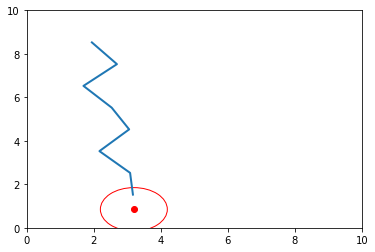

In [125]:
# test prediction
env = SimpleWalk2Dcont()
env.reset()

while True:
    action, _states = model.predict(env.state)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
env.render()


In [126]:
evaluate_policy(model, env, n_eval_episodes=10, render=False)

DEBUG:root:init distance to goal: 2.3155887757796316
DEBUG:root:movement: 1.010778753107599
DEBUG:root:reached goal
DEBUG:root:init distance to goal: 1.7045264629778591
DEBUG:root:reached goal
DEBUG:root:init distance to goal: 1.236541454091132
DEBUG:root:reached goal
DEBUG:root:init distance to goal: 7.195750857390799
DEBUG:root:movement: 1.3344609136360175
DEBUG:root:movement: 1.286291669669704
DEBUG:root:movement: 1.1826593632236206
DEBUG:root:movement: 0.9149987098272763
DEBUG:root:movement: 0.99729152485502
DEBUG:root:reached goal
DEBUG:root:init distance to goal: 6.809765744669524
DEBUG:root:movement: 0.92699123142999
DEBUG:root:movement: 0.701933085606008
DEBUG:root:movement: 1.1005349367820862
DEBUG:root:movement: 1.213739542261393
DEBUG:root:movement: 1.0421282129657985
DEBUG:root:reached goal
DEBUG:root:init distance to goal: 3.6177089205520576
DEBUG:root:movement: 1.2703484326372756
DEBUG:root:movement: 1.0322184724833738
DEBUG:root:reached goal
DEBUG:root:init distance to g

(1139.477346801758, 703.8701100442527)

DEBUG:root:init distance to goal: 1.4633173497072083
DEBUG:root:reached goal
DEBUG:root:Steps taken: 1
DEBUG:root:distance to goal: 0.3346251346927712
INFO:root:Episode:1 Score:2000.0
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Luttk\.vscode-insiders\extensions\ms-toolsai.jupyter-2022.1.1001614873\pythonFiles\vscode_datascience_helpers\kernel_prewarm_starter.py", line 31, in <module>
    runpy

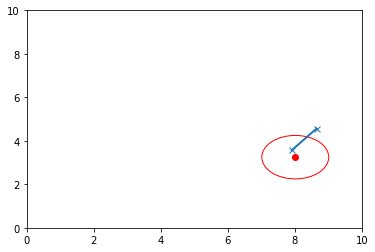

DEBUG:root:init distance to goal: 4.4136870659086815
DEBUG:root:movement: 1.2194518218858064
DEBUG:root:Steps taken: 1
DEBUG:root:distance to goal: 3.194235244022875
DEBUG:root:movement: 0.9749332286993364
DEBUG:root:Steps taken: 2
DEBUG:root:distance to goal: 2.2193020153235388
DEBUG:root:movement: 1.0352955283961858
DEBUG:root:Steps taken: 3
DEBUG:root:distance to goal: 1.184006486927353
DEBUG:root:reached goal
DEBUG:root:Steps taken: 4
DEBUG:root:distance to goal: 0.20281946169487397
INFO:root:Episode:2 Score:822.9680578981329
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Luttk\anaconda

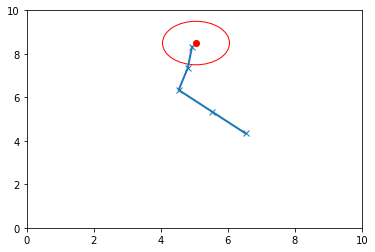

DEBUG:root:init distance to goal: 6.871017152845994
DEBUG:root:movement: 0.9519185790751603
DEBUG:root:Steps taken: 1
DEBUG:root:distance to goal: 5.9190985737708335
DEBUG:root:movement: 0.9211113803608857
DEBUG:root:Steps taken: 2
DEBUG:root:distance to goal: 4.997987193409948
DEBUG:root:movement: 0.863475231304295
DEBUG:root:Steps taken: 3
DEBUG:root:distance to goal: 4.134511962105653
DEBUG:root:movement: 1.3164877014887781
DEBUG:root:Steps taken: 4
DEBUG:root:distance to goal: 2.8180242606168746
DEBUG:root:movement: 1.014852523381805
DEBUG:root:Steps taken: 5
DEBUG:root:distance to goal: 1.8031717372350695
DEBUG:root:reached goal
DEBUG:root:Steps taken: 6
DEBUG:root:distance to goal: 0.6675085560223596
INFO:root:Episode:3 Score:6.784541561092283
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__in

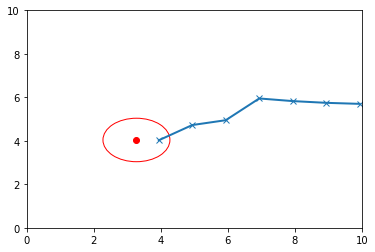

DEBUG:root:init distance to goal: 1.872240063301893
DEBUG:root:reached goal
DEBUG:root:Steps taken: 1
DEBUG:root:distance to goal: 0.8729396400887475
INFO:root:Episode:4 Score:2000.0
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Luttk\.vscode-insiders\extensions\ms-toolsai.jupyter-2022.1.1001614873\pythonFiles\vscode_datascience_helpers\kernel_prewarm_starter.py", line 31, in <module>
    runpy.

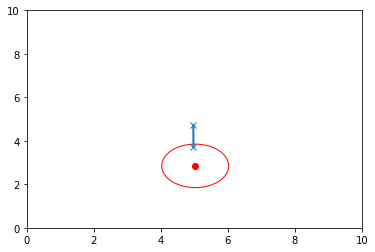

DEBUG:root:init distance to goal: 3.536256702977296
DEBUG:root:movement: 1.3489123921468522
DEBUG:root:Steps taken: 1
DEBUG:root:distance to goal: 2.187344310830444
DEBUG:root:movement: 1.1559434258205143
DEBUG:root:Steps taken: 2
DEBUG:root:distance to goal: 1.0314008850099297
DEBUG:root:reached goal
DEBUG:root:Steps taken: 3
DEBUG:root:distance to goal: 0.20195576760361833
INFO:root:Episode:5 Score:1250.4855817967368
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arg

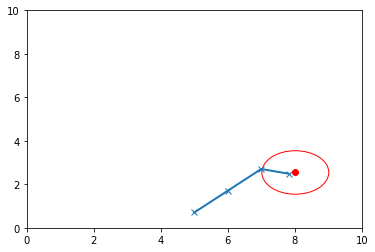

DEBUG:root:init distance to goal: 4.304315073839886
DEBUG:root:movement: 1.0742857442931921
DEBUG:root:Steps taken: 1
DEBUG:root:distance to goal: 3.230029329546694
DEBUG:root:movement: 1.0048534208473199
DEBUG:root:Steps taken: 2
DEBUG:root:distance to goal: 2.225175908699374
DEBUG:root:movement: 0.999668346716148
DEBUG:root:Steps taken: 3
DEBUG:root:distance to goal: 1.225507561983226
DEBUG:root:reached goal
DEBUG:root:Steps taken: 4
DEBUG:root:distance to goal: 0.22549484274856268
INFO:root:Episode:6 Score:807.880751185666
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Luttk\anaconda3\en

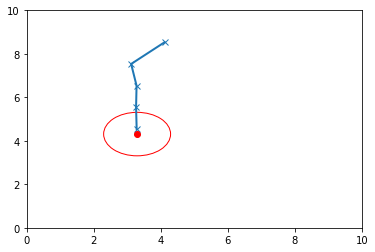

DEBUG:root:init distance to goal: 7.656119369456605
DEBUG:root:movement: 1.111826407566479
DEBUG:root:Steps taken: 1
DEBUG:root:distance to goal: 6.544292961890126
DEBUG:root:movement: 0.9729935811275352
DEBUG:root:Steps taken: 2
DEBUG:root:distance to goal: 5.571299380762591
DEBUG:root:movement: 1.0226612584723496
DEBUG:root:Steps taken: 3
DEBUG:root:distance to goal: 4.5486381222902414
DEBUG:root:movement: 0.9567107172096563
DEBUG:root:Steps taken: 4
DEBUG:root:distance to goal: 3.591927405080585
DEBUG:root:movement: 1.0358665658440587
DEBUG:root:Steps taken: 5
DEBUG:root:distance to goal: 2.5560608392365265
DEBUG:root:movement: 0.9024971308126561
DEBUG:root:Steps taken: 6
DEBUG:root:distance to goal: 1.6535637084238703
DEBUG:root:reached goal
DEBUG:root:Steps taken: 7
DEBUG:root:distance to goal: 0.534590898976947
INFO:root:Episode:7 Score:-399.7444338967266
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py

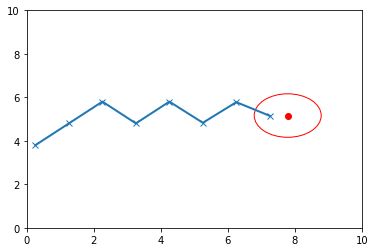

DEBUG:root:init distance to goal: 7.262486264869094
DEBUG:root:movement: 1.4012198240862261
DEBUG:root:Steps taken: 1
DEBUG:root:distance to goal: 5.861266440782868
DEBUG:root:movement: 1.393024971000524
DEBUG:root:Steps taken: 2
DEBUG:root:distance to goal: 4.468241469782344
DEBUG:root:movement: 1.3737432269782062
DEBUG:root:Steps taken: 3
DEBUG:root:distance to goal: 3.0944982428041374
DEBUG:root:movement: 1.3093772617070283
DEBUG:root:Steps taken: 4
DEBUG:root:distance to goal: 1.7851209810971091
DEBUG:root:reached goal
DEBUG:root:Steps taken: 5
DEBUG:root:distance to goal: 0.7230117364748003
INFO:root:Episode:8 Score:547.7365283771983
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\log

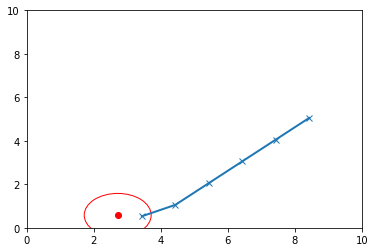

DEBUG:root:init distance to goal: 1.7137105150796235
DEBUG:root:reached goal
DEBUG:root:Steps taken: 1
DEBUG:root:distance to goal: 0.5467700907122883
INFO:root:Episode:9 Score:2000.0
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Luttk\.vscode-insiders\extensions\ms-toolsai.jupyter-2022.1.1001614873\pythonFiles\vscode_datascience_helpers\kernel_prewarm_starter.py", line 31, in <module>
    runpy

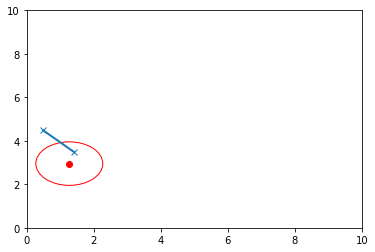

DEBUG:root:init distance to goal: 2.5063661689157968
DEBUG:root:movement: 1.3928659644101689
DEBUG:root:Steps taken: 1
DEBUG:root:distance to goal: 1.113500204505628
DEBUG:root:reached goal
DEBUG:root:Steps taken: 2
DEBUG:root:distance to goal: 0.211991268624469
INFO:root:Episode:10 Score:1639.2865964410169
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Luttk\.vscode-insiders\extensions\ms-toolsa

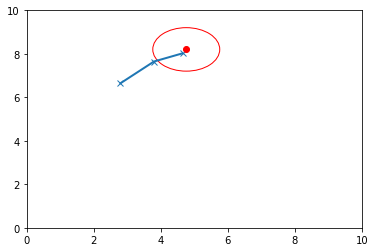

In [129]:
logger.setLevel(logging.DEBUG)
env = SimpleWalk2Dcont()
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        # env.render()
        action, _state = model.predict(state)
        n_state, reward, done, info = env.step(action)
        logging.debug('Steps taken: {}'.format(info['steps_taken']))
        logging.debug('distance to goal: {}'.format(info['distance_to_goal']))
        score+=reward
    logging.info('Episode:{} Score:{}'.format(episode, score))
    env.render()
env.close()

## Remarks

PPO_26

training looks stable till step 80k 

training sufficient after 15k

## TODO

calculate minimum number of steps and set this as reward zero.
Penalize hard if it takes longer than ideal